In [4]:
!python -V

Python 3.9.19


In [5]:
import pandas as pd

In [6]:
import pickle

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [9]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("my-experiment")

<Experiment: artifact_location='/workspaces/mlops/02-Experiment_Tracking/mlruns/1', creation_time=1716555313243, experiment_id='1', last_update_time=1716555313243, lifecycle_stage='active', name='my-experiment', tags={'mlflow.sharedViewState.399ac639b9706e2217d074fa8e075ecb3e5c4b8f006adf40a809918a20b73f4b': '{"searchFilter":"","orderByKey":"attributes.start_time","orderByAsc":false,"startTime":"ALL","lifecycleFilter":"Active","datasetsFilter":[],"modelVersionFilter":"All '
                                                                                            'Runs","selectedColumns":["metrics.`rmse`","params.`alpha`","params.`train-data-link`","params.`val-data-link`","tags.`developer`"],"runsExpanded":{},"runsPinned":[],"runsHidden":[],"runsHiddenMode":"FIRST_10_RUNS","compareRunCharts":[{"uuid":"1716571159702csbzl512","type":"BAR","runsCountToCompare":10,"metricSectionId":"1716571159702iydtxt7k","deleted":false,"isGenerated":true,"metricKey":"rmse"}],"compareRunSections":[{"uuid

In [10]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [11]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829628

/tmp/ipykernel_2684/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2684/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


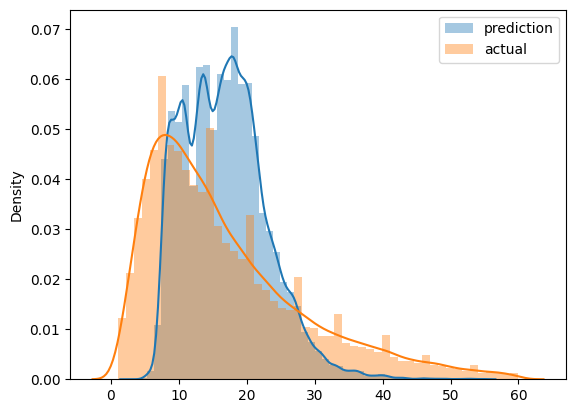

In [12]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [13]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [14]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [15]:
len(df_train), len(df_val)

(73908, 61921)

In [16]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [17]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [18]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715200888857

In [20]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [25]:
with mlflow.start_run():

    mlflow.set_tag("developer", "cristian")

    mlflow.log_param("train-data-link", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-link", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)


    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")


/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
import xgboost as xgb

In [23]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [24]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [26]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [27]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:40:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.26424                           
[1]	validation-rmse:7.84854                           
[2]	validation-rmse:7.21337                           
[3]	validation-rmse:6.93033                           
[4]	validation-rmse:6.79286                           
[5]	validation-rmse:6.72170                           
[6]	validation-rmse:6.68115                           
[7]	validation-rmse:6.65464                           
[8]	validation-rmse:6.63754                           
[9]	validation-rmse:6.62386                           
[10]	validation-rmse:6.61580                          
[11]	validation-rmse:6.60939                          
[12]	validation-rmse:6.60345                          
[13]	validation-rmse:6.60171                          
[14]	validation-rmse:6.59760                          
[15]	validation-rmse:6.59660                          
[16]	validation-rmse:6.59322                          
[17]	validation-rmse:6.59195                          
[18]	valid

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:41:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.38870                                                    
[1]	validation-rmse:7.95757                                                    
[2]	validation-rmse:7.26036                                                    
[3]	validation-rmse:6.93197                                                    
[4]	validation-rmse:6.75270                                                    
[5]	validation-rmse:6.66981                                                    
[6]	validation-rmse:6.61858                                                    
[7]	validation-rmse:6.58238                                                    
[8]	validation-rmse:6.56107                                                    
[9]	validation-rmse:6.54982                                                    
[10]	validation-rmse:6.54112                                                   
[11]	validation-rmse:6.53666                                                   
[12]	validation-rmse:6.52839            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:42:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.22984                                                    
[1]	validation-rmse:6.76135                                                    
[2]	validation-rmse:6.67941                                                    
[3]	validation-rmse:6.64781                                                    
[4]	validation-rmse:6.63820                                                    
[5]	validation-rmse:6.63279                                                    
[6]	validation-rmse:6.62772                                                    
[7]	validation-rmse:6.61726                                                    
[8]	validation-rmse:6.61562                                                    
[9]	validation-rmse:6.61225                                                    
[10]	validation-rmse:6.60904                                                   
[11]	validation-rmse:6.60768                                                   
[12]	validation-rmse:6.60557            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:43:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.94583                                                    
[1]	validation-rmse:6.57055                                                    
[2]	validation-rmse:6.52778                                                    
[3]	validation-rmse:6.51580                                                    
[4]	validation-rmse:6.50013                                                    
[5]	validation-rmse:6.48852                                                    
[6]	validation-rmse:6.48197                                                    
[7]	validation-rmse:6.47621                                                    
[8]	validation-rmse:6.46893                                                    
[9]	validation-rmse:6.45973                                                    
[10]	validation-rmse:6.45328                                                   
[11]	validation-rmse:6.44988                                                   
[12]	validation-rmse:6.44137            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:43:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.52017                                                    
[1]	validation-rmse:7.26217                                                    
[2]	validation-rmse:6.85408                                                    
[3]	validation-rmse:6.69495                                                    
[4]	validation-rmse:6.62626                                                    
[5]	validation-rmse:6.59865                                                    
[6]	validation-rmse:6.58009                                                    
[7]	validation-rmse:6.56946                                                    
[8]	validation-rmse:6.56204                                                    
[9]	validation-rmse:6.55579                                                    
[10]	validation-rmse:6.55028                                                   
[11]	validation-rmse:6.54648                                                   
[12]	validation-rmse:6.54275            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:44:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.39052                                                   
[1]	validation-rmse:9.13042                                                    
[2]	validation-rmse:8.27819                                                    
[3]	validation-rmse:7.71758                                                    
[4]	validation-rmse:7.35137                                                    
[5]	validation-rmse:7.11160                                                    
[6]	validation-rmse:6.95816                                                    
[7]	validation-rmse:6.85362                                                    
[8]	validation-rmse:6.78424                                                    
[9]	validation-rmse:6.73767                                                    
[10]	validation-rmse:6.70504                                                   
[11]	validation-rmse:6.68242                                                   
[12]	validation-rmse:6.66277            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:45:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.85221                                                    
[1]	validation-rmse:7.47002                                                    
[2]	validation-rmse:6.95251                                                    
[3]	validation-rmse:6.74987                                                    
[4]	validation-rmse:6.64367                                                    
[5]	validation-rmse:6.60424                                                    
[6]	validation-rmse:6.57810                                                    
[7]	validation-rmse:6.56291                                                    
[8]	validation-rmse:6.55449                                                    
[9]	validation-rmse:6.54801                                                    
[10]	validation-rmse:6.54460                                                   
[11]	validation-rmse:6.53825                                                   
[12]	validation-rmse:6.53645            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:45:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.33548                                                   
[1]	validation-rmse:10.58377                                                   
[2]	validation-rmse:9.94293                                                    
[3]	validation-rmse:9.39883                                                    
[4]	validation-rmse:8.93975                                                    
[5]	validation-rmse:8.55455                                                    
[6]	validation-rmse:8.23300                                                    
[7]	validation-rmse:7.96431                                                    
[8]	validation-rmse:7.74098                                                    
[9]	validation-rmse:7.55633                                                    
[10]	validation-rmse:7.40326                                                   
[11]	validation-rmse:7.27541                                                   
[12]	validation-rmse:7.17010            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:48:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.99127                                                    
[1]	validation-rmse:6.69740                                                    
[2]	validation-rmse:6.67083                                                    
[3]	validation-rmse:6.66383                                                    
[4]	validation-rmse:6.65837                                                    
[5]	validation-rmse:6.64774                                                    
[6]	validation-rmse:6.64009                                                    
[7]	validation-rmse:6.63069                                                    
[8]	validation-rmse:6.62283                                                    
[9]	validation-rmse:6.62124                                                    
[10]	validation-rmse:6.62009                                                   
[11]	validation-rmse:6.61455                                                   
[12]	validation-rmse:6.60845            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:48:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.06141                                                    
[1]	validation-rmse:7.60051                                                    
[2]	validation-rmse:6.97622                                                    
[3]	validation-rmse:6.70390                                                    
[4]	validation-rmse:6.58084                                                    
[5]	validation-rmse:6.51681                                                    
[6]	validation-rmse:6.48184                                                    
[7]	validation-rmse:6.46220                                                    
[8]	validation-rmse:6.44670                                                    
[9]	validation-rmse:6.43524                                                    
[10]	validation-rmse:6.42893                                                   
[11]	validation-rmse:6.42420                                                   
[12]	validation-rmse:6.42046            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:49:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.38387                                                     
[1]	validation-rmse:6.81079                                                     
[2]	validation-rmse:6.72314                                                     
[3]	validation-rmse:6.69970                                                     
[4]	validation-rmse:6.69167                                                     
[5]	validation-rmse:6.68813                                                     
[6]	validation-rmse:6.67976                                                     
[7]	validation-rmse:6.67085                                                     
[8]	validation-rmse:6.66560                                                     
[9]	validation-rmse:6.65289                                                     
[10]	validation-rmse:6.65000                                                    
[11]	validation-rmse:6.64683                                                    
[12]	validation-rmse:6.64249

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:50:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.89938                                                    
[1]	validation-rmse:9.87762                                                     
[2]	validation-rmse:9.09276                                                     
[3]	validation-rmse:8.49749                                                     
[4]	validation-rmse:8.05088                                                     
[5]	validation-rmse:7.71858                                                     
[6]	validation-rmse:7.47269                                                     
[7]	validation-rmse:7.28881                                                     
[8]	validation-rmse:7.15273                                                     
[9]	validation-rmse:7.05225                                                     
[10]	validation-rmse:6.97834                                                    
[11]	validation-rmse:6.92262                                                    
[12]	validation-rmse:6.87984

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:51:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.90144                                                     
[1]	validation-rmse:8.51458                                                     
[2]	validation-rmse:7.71999                                                     
[3]	validation-rmse:7.27426                                                     
[4]	validation-rmse:7.02557                                                     
[5]	validation-rmse:6.88568                                                     
[6]	validation-rmse:6.80395                                                     
[7]	validation-rmse:6.75310                                                     
[8]	validation-rmse:6.72330                                                     
[9]	validation-rmse:6.70129                                                     
[10]	validation-rmse:6.68573                                                    
[11]	validation-rmse:6.67519                                                    
[12]	validation-rmse:6.66625

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:52:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.40300                                                    
[1]	validation-rmse:10.70020                                                    
[2]	validation-rmse:10.09313                                                    
[3]	validation-rmse:9.57058                                                     
[4]	validation-rmse:9.12320                                                     
[5]	validation-rmse:8.74072                                                     
[6]	validation-rmse:8.41589                                                     
[7]	validation-rmse:8.14051                                                     
[8]	validation-rmse:7.90834                                                     
[9]	validation-rmse:7.71122                                                     
[10]	validation-rmse:7.54598                                                    
[11]	validation-rmse:7.40698                                                    
[12]	validation-rmse:7.29063

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:54:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.36376                                                    
[1]	validation-rmse:10.62933                                                    
[2]	validation-rmse:9.99599                                                     
[3]	validation-rmse:9.45183                                                     
[4]	validation-rmse:8.98653                                                     
[5]	validation-rmse:8.59185                                                     
[6]	validation-rmse:8.25493                                                     
[7]	validation-rmse:7.97316                                                     
[8]	validation-rmse:7.73532                                                     
[9]	validation-rmse:7.53546                                                     
[10]	validation-rmse:7.36832                                                    
[11]	validation-rmse:7.22841                                                    
[12]	validation-rmse:7.11059

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:57:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.74723                                                       
[1]	validation-rmse:11.31523                                                       
[2]	validation-rmse:10.91489                                                       
[3]	validation-rmse:10.54536                                                       
[4]	validation-rmse:10.20281                                                       
[5]	validation-rmse:9.88841                                                        
[6]	validation-rmse:9.59790                                                        
[7]	validation-rmse:9.33131                                                        
[8]	validation-rmse:9.08578                                                        
[9]	validation-rmse:8.85975                                                        
[10]	validation-rmse:8.65221                                                       
[11]	validation-rmse:8.46296                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:01:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.69574                                                       
[1]	validation-rmse:11.22094                                                       
[2]	validation-rmse:10.78552                                                       
[3]	validation-rmse:10.38671                                                       
[4]	validation-rmse:10.02241                                                       
[5]	validation-rmse:9.69028                                                        
[6]	validation-rmse:9.38768                                                        
[7]	validation-rmse:9.11241                                                        
[8]	validation-rmse:8.86202                                                        
[9]	validation-rmse:8.63513                                                        
[10]	validation-rmse:8.42964                                                       
[11]	validation-rmse:8.24381                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:04:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.42095                                                        
[1]	validation-rmse:7.96042                                                        
[2]	validation-rmse:7.23775                                                        
[3]	validation-rmse:6.88871                                                        
[4]	validation-rmse:6.71296                                                        
[5]	validation-rmse:6.62418                                                        
[6]	validation-rmse:6.57240                                                        
[7]	validation-rmse:6.53660                                                        
[8]	validation-rmse:6.51732                                                        
[9]	validation-rmse:6.50363                                                        
[10]	validation-rmse:6.49098                                                       
[11]	validation-rmse:6.47959                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:05:30] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.50011                                                        
[1]	validation-rmse:8.03341                                                        
[2]	validation-rmse:7.27963                                                        
[3]	validation-rmse:6.90388                                                        
[4]	validation-rmse:6.71337                                                        
[5]	validation-rmse:6.60883                                                        
[6]	validation-rmse:6.54934                                                        
[7]	validation-rmse:6.51394                                                        
[8]	validation-rmse:6.48871                                                        
[9]	validation-rmse:6.47142                                                        
[10]	validation-rmse:6.46081                                                       
[11]	validation-rmse:6.45229                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:06:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.52236                                                     
[1]	validation-rmse:9.31392                                                      
[2]	validation-rmse:8.46723                                                      
[3]	validation-rmse:7.88448                                                      
[4]	validation-rmse:7.48994                                                      
[5]	validation-rmse:7.22197                                                      
[6]	validation-rmse:7.04396                                                      
[7]	validation-rmse:6.92352                                                      
[8]	validation-rmse:6.83481                                                      
[9]	validation-rmse:6.77399                                                      
[10]	validation-rmse:6.73058                                                     
[11]	validation-rmse:6.69931                                                     
[12]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:08:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.78640                                                     
[1]	validation-rmse:11.39016                                                     
[2]	validation-rmse:11.02007                                                     
[3]	validation-rmse:10.67715                                                     
[4]	validation-rmse:10.35895                                                     
[5]	validation-rmse:10.06295                                                     
[6]	validation-rmse:9.78591                                                      
[7]	validation-rmse:9.53334                                                      
[8]	validation-rmse:9.29648                                                      
[9]	validation-rmse:9.07753                                                      
[10]	validation-rmse:8.87569                                                     
[11]	validation-rmse:8.69238                                                     
[12]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:13:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.49539                                                       
[1]	validation-rmse:10.86019                                                       
[2]	validation-rmse:10.30021                                                       
[3]	validation-rmse:9.80621                                                        
[4]	validation-rmse:9.37466                                                        
[5]	validation-rmse:8.99456                                                        
[6]	validation-rmse:8.66545                                                        
[7]	validation-rmse:8.37769                                                        
[8]	validation-rmse:8.12887                                                        
[9]	validation-rmse:7.91259                                                        
[10]	validation-rmse:7.72422                                                       
[11]	validation-rmse:7.56429                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:16:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.64031                                                       
[1]	validation-rmse:11.12035                                                       
[2]	validation-rmse:10.64913                                                       
[3]	validation-rmse:10.22211                                                       
[4]	validation-rmse:9.83730                                                        
[5]	validation-rmse:9.49010                                                        
[6]	validation-rmse:9.17767                                                        
[7]	validation-rmse:8.89680                                                        
[8]	validation-rmse:8.64518                                                        
[9]	validation-rmse:8.42151                                                        
[10]	validation-rmse:8.21857                                                       
[11]	validation-rmse:8.03923                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:17:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.80891                                                       
[1]	validation-rmse:11.43102                                                       
[2]	validation-rmse:11.07794                                                       
[3]	validation-rmse:10.74835                                                       
[4]	validation-rmse:10.44069                                                       
[5]	validation-rmse:10.15415                                                       
[6]	validation-rmse:9.88826                                                        
[7]	validation-rmse:9.63987                                                        
[8]	validation-rmse:9.41064                                                        
[9]	validation-rmse:9.19639                                                        
[10]	validation-rmse:8.99881                                                       
[11]	validation-rmse:8.81438                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:20:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.54766                                                       
[1]	validation-rmse:10.95369                                                       
[2]	validation-rmse:10.42399                                                       
[3]	validation-rmse:9.95248                                                        
[4]	validation-rmse:9.53482                                                        
[5]	validation-rmse:9.16511                                                        
[6]	validation-rmse:8.83854                                                        
[7]	validation-rmse:8.55111                                                        
[8]	validation-rmse:8.29991                                                        
[9]	validation-rmse:8.07832                                                        
[10]	validation-rmse:7.88464                                                       
[11]	validation-rmse:7.71502                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:23:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.53393                                                       
[1]	validation-rmse:10.93062                                                       
[2]	validation-rmse:10.39608                                                       
[3]	validation-rmse:9.92124                                                        
[4]	validation-rmse:9.50183                                                        
[5]	validation-rmse:9.13489                                                        
[6]	validation-rmse:8.81022                                                        
[7]	validation-rmse:8.52849                                                        
[8]	validation-rmse:8.27951                                                        
[9]	validation-rmse:8.06457                                                        
[10]	validation-rmse:7.87847                                                       
[11]	validation-rmse:7.71324                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:25:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.96873                                                     
[1]	validation-rmse:9.98644                                                      
[2]	validation-rmse:9.22405                                                      
[3]	validation-rmse:8.63510                                                      
[4]	validation-rmse:8.18585                                                      
[5]	validation-rmse:7.84616                                                      
[6]	validation-rmse:7.59063                                                      
[7]	validation-rmse:7.39642                                                      
[8]	validation-rmse:7.25212                                                      
[9]	validation-rmse:7.14409                                                      
[10]	validation-rmse:7.06078                                                     
[11]	validation-rmse:6.99880                                                     
[12]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:26:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.14625                                                     
[1]	validation-rmse:10.26514                                                     
[2]	validation-rmse:9.53874                                                      
[3]	validation-rmse:8.94761                                                      
[4]	validation-rmse:8.46765                                                      
[5]	validation-rmse:8.08301                                                      
[6]	validation-rmse:7.77631                                                      
[7]	validation-rmse:7.52926                                                      
[8]	validation-rmse:7.33064                                                      
[9]	validation-rmse:7.17363                                                      
[10]	validation-rmse:7.04693                                                     
[11]	validation-rmse:6.94750                                                     
[12]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:27:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.11642                                                     
[1]	validation-rmse:10.22202                                                     
[2]	validation-rmse:9.49243                                                      
[3]	validation-rmse:8.90649                                                      
[4]	validation-rmse:8.43679                                                      
[5]	validation-rmse:8.06245                                                      
[6]	validation-rmse:7.76767                                                      
[7]	validation-rmse:7.53339                                                      
[8]	validation-rmse:7.34702                                                      
[9]	validation-rmse:7.20367                                                      
[10]	validation-rmse:7.08850                                                     
[11]	validation-rmse:6.99642                                                     
[12]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:29:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.22760                                                     
[1]	validation-rmse:10.40449                                                     
[2]	validation-rmse:9.71468                                                      
[3]	validation-rmse:9.14520                                                      
[4]	validation-rmse:8.67497                                                      
[5]	validation-rmse:8.28618                                                      
[6]	validation-rmse:7.97584                                                      
[7]	validation-rmse:7.71839                                                      
[8]	validation-rmse:7.50635                                                      
[9]	validation-rmse:7.34071                                                      
[10]	validation-rmse:7.20478                                                     
[11]	validation-rmse:7.08801                                                     
[12]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:31:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.02868                                                     
[1]	validation-rmse:10.07348                                                     
[2]	validation-rmse:9.30876                                                      
[3]	validation-rmse:8.70006                                                      
[4]	validation-rmse:8.22118                                                      
[5]	validation-rmse:7.84967                                                      
[6]	validation-rmse:7.55835                                                      
[7]	validation-rmse:7.33470                                                      
[8]	validation-rmse:7.15977                                                      
[9]	validation-rmse:7.02446                                                      
[10]	validation-rmse:6.91881                                                     
[11]	validation-rmse:6.83683                                                     
[12]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:32:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.52603                                                     
[1]	validation-rmse:9.30829                                                      
[2]	validation-rmse:8.44307                                                      
[3]	validation-rmse:7.84365                                                      
[4]	validation-rmse:7.43297                                                      
[5]	validation-rmse:7.14609                                                      
[6]	validation-rmse:6.95351                                                      
[7]	validation-rmse:6.81940                                                      
[8]	validation-rmse:6.72910                                                      
[9]	validation-rmse:6.66386                                                      
[10]	validation-rmse:6.61615                                                     
[11]	validation-rmse:6.57952                                                     
[12]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:34:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.53843                                                    
[1]	validation-rmse:10.94041                                                    
[2]	validation-rmse:10.40844                                                    
[3]	validation-rmse:9.93781                                                     
[4]	validation-rmse:9.52272                                                     
[5]	validation-rmse:9.15628                                                     
[6]	validation-rmse:8.83573                                                     
[7]	validation-rmse:8.55268                                                     
[8]	validation-rmse:8.30846                                                     
[9]	validation-rmse:8.09459                                                     
[10]	validation-rmse:7.90536                                                    
[11]	validation-rmse:7.74332                                                    
[12]	validation-rmse:7.60221

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:35:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.66435                                                    
[1]	validation-rmse:9.52058                                                     
[2]	validation-rmse:8.68144                                                     
[3]	validation-rmse:8.08222                                                     
[4]	validation-rmse:7.64809                                                     
[5]	validation-rmse:7.34242                                                     
[6]	validation-rmse:7.12990                                                     
[7]	validation-rmse:6.98293                                                     
[8]	validation-rmse:6.87863                                                     
[9]	validation-rmse:6.79726                                                     
[10]	validation-rmse:6.73710                                                    
[11]	validation-rmse:6.69259                                                    
[12]	validation-rmse:6.65645

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:37:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.06154                                                    
[1]	validation-rmse:8.68976                                                     
[2]	validation-rmse:7.84363                                                     
[3]	validation-rmse:7.32968                                                     
[4]	validation-rmse:7.02594                                                     
[5]	validation-rmse:6.84229                                                     
[6]	validation-rmse:6.72844                                                     
[7]	validation-rmse:6.65715                                                     
[8]	validation-rmse:6.61036                                                     
[9]	validation-rmse:6.57898                                                     
[10]	validation-rmse:6.55755                                                    
[11]	validation-rmse:6.54326                                                    
[12]	validation-rmse:6.52994

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:37:48] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.64275                                                    
[1]	validation-rmse:11.12370                                                    
[2]	validation-rmse:10.65286                                                    
[3]	validation-rmse:10.22644                                                    
[4]	validation-rmse:9.84061                                                     
[5]	validation-rmse:9.49273                                                     
[6]	validation-rmse:9.17826                                                     
[7]	validation-rmse:8.89577                                                     
[8]	validation-rmse:8.64219                                                     
[9]	validation-rmse:8.41444                                                     
[10]	validation-rmse:8.21142                                                    
[11]	validation-rmse:8.02852                                                    
[12]	validation-rmse:7.86575

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:40:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.87835                                                     
[1]	validation-rmse:6.84136                                                     
[2]	validation-rmse:6.59670                                                     
[3]	validation-rmse:6.51998                                                     
[4]	validation-rmse:6.49098                                                     
[5]	validation-rmse:6.48227                                                     
[6]	validation-rmse:6.47338                                                     
[7]	validation-rmse:6.46642                                                     
[8]	validation-rmse:6.45675                                                     
[9]	validation-rmse:6.45299                                                     
[10]	validation-rmse:6.45002                                                    
[11]	validation-rmse:6.44281                                                    
[12]	validation-rmse:6.43809

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:40:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.21961                                                    
[1]	validation-rmse:10.38558                                                    
[2]	validation-rmse:9.68857                                                     
[3]	validation-rmse:9.11078                                                     
[4]	validation-rmse:8.63138                                                     
[5]	validation-rmse:8.23918                                                     
[6]	validation-rmse:7.91989                                                     
[7]	validation-rmse:7.65661                                                     
[8]	validation-rmse:7.44366                                                     
[9]	validation-rmse:7.27205                                                     
[10]	validation-rmse:7.13235                                                    
[11]	validation-rmse:7.01929                                                    
[12]	validation-rmse:6.92608

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:42:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.25866                                                      
[1]	validation-rmse:8.94072                                                       
[2]	validation-rmse:8.08219                                                       
[3]	validation-rmse:7.53624                                                       
[4]	validation-rmse:7.19291                                                       
[5]	validation-rmse:6.97563                                                       
[6]	validation-rmse:6.83409                                                       
[7]	validation-rmse:6.74371                                                       
[8]	validation-rmse:6.67469                                                       
[9]	validation-rmse:6.63639                                                       
[10]	validation-rmse:6.61077                                                      
[11]	validation-rmse:6.58645                                                      
[12]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:43:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.77264                                                      
[1]	validation-rmse:9.68482                                                       
[2]	validation-rmse:8.87576                                                       
[3]	validation-rmse:8.28301                                                       
[4]	validation-rmse:7.85442                                                       
[5]	validation-rmse:7.54637                                                       
[6]	validation-rmse:7.32569                                                       
[7]	validation-rmse:7.16784                                                       
[8]	validation-rmse:7.05317                                                       
[9]	validation-rmse:6.97101                                                       
[10]	validation-rmse:6.91298                                                      
[11]	validation-rmse:6.86828                                                      
[12]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:45:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.45567                                                      
[1]	validation-rmse:10.79339                                                      
[2]	validation-rmse:10.21549                                                      
[3]	validation-rmse:9.71334                                                       
[4]	validation-rmse:9.27916                                                       
[5]	validation-rmse:8.90463                                                       
[6]	validation-rmse:8.58302                                                       
[7]	validation-rmse:8.30742                                                       
[8]	validation-rmse:8.07086                                                       
[9]	validation-rmse:7.86980                                                       
[10]	validation-rmse:7.69885                                                      
[11]	validation-rmse:7.55333                                                      
[12]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:46:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.23274                                                      
[1]	validation-rmse:10.40621                                                      
[2]	validation-rmse:9.71375                                                       
[3]	validation-rmse:9.13702                                                       
[4]	validation-rmse:8.66023                                                       
[5]	validation-rmse:8.26674                                                       
[6]	validation-rmse:7.94490                                                       
[7]	validation-rmse:7.68158                                                       
[8]	validation-rmse:7.46799                                                       
[9]	validation-rmse:7.29399                                                       
[10]	validation-rmse:7.15389                                                      
[11]	validation-rmse:7.03984                                                      
[12]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:48:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.69297                                                      
[1]	validation-rmse:11.21534                                                      
[2]	validation-rmse:10.77745                                                      
[3]	validation-rmse:10.37695                                                      
[4]	validation-rmse:10.01173                                                      
[5]	validation-rmse:9.67822                                                       
[6]	validation-rmse:9.37415                                                       
[7]	validation-rmse:9.09719                                                       
[8]	validation-rmse:8.84491                                                       
[9]	validation-rmse:8.61679                                                       
[10]	validation-rmse:8.41000                                                      
[11]	validation-rmse:8.22339                                                      
[12]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:51:48] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.93397                                                       
[1]	validation-rmse:9.91934                                                        
[2]	validation-rmse:9.12204                                                        
[3]	validation-rmse:8.49936                                                        
[4]	validation-rmse:8.02379                                                        
[5]	validation-rmse:7.65734                                                        
[6]	validation-rmse:7.38009                                                        
[7]	validation-rmse:7.17062                                                        
[8]	validation-rmse:7.01210                                                        
[9]	validation-rmse:6.88993                                                        
[10]	validation-rmse:6.79498                                                       
[11]	validation-rmse:6.72366                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:53:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.44278                                                       
[1]	validation-rmse:10.76587                                                       
[2]	validation-rmse:10.17456                                                       
[3]	validation-rmse:9.65971                                                        
[4]	validation-rmse:9.21234                                                        
[5]	validation-rmse:8.82382                                                        
[6]	validation-rmse:8.48908                                                        
[7]	validation-rmse:8.20064                                                        
[8]	validation-rmse:7.95358                                                        
[9]	validation-rmse:7.74221                                                        
[10]	validation-rmse:7.56237                                                       
[11]	validation-rmse:7.40612                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:55:51] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.29699                                                       
[1]	validation-rmse:10.51734                                                       
[2]	validation-rmse:9.85693                                                        
[3]	validation-rmse:9.30135                                                        
[4]	validation-rmse:8.83484                                                        
[5]	validation-rmse:8.44664                                                        
[6]	validation-rmse:8.12397                                                        
[7]	validation-rmse:7.85745                                                        
[8]	validation-rmse:7.63810                                                        
[9]	validation-rmse:7.45791                                                        
[10]	validation-rmse:7.30906                                                       
[11]	validation-rmse:7.18605                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:57:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.83779                                                       
[1]	validation-rmse:9.77713                                                        
[2]	validation-rmse:8.96905                                                        
[3]	validation-rmse:8.36479                                                        
[4]	validation-rmse:7.91288                                                        
[5]	validation-rmse:7.57681                                                        
[6]	validation-rmse:7.33377                                                        
[7]	validation-rmse:7.15397                                                        
[8]	validation-rmse:7.02037                                                        
[9]	validation-rmse:6.92205                                                        
[10]	validation-rmse:6.84821                                                       
[11]	validation-rmse:6.79277                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:59:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.86118                                                        
[1]	validation-rmse:8.46162                                                        
[2]	validation-rmse:7.63144                                                        
[3]	validation-rmse:7.16753                                                        
[4]	validation-rmse:6.92525                                                        
[5]	validation-rmse:6.77762                                                        
[6]	validation-rmse:6.69344                                                        
[7]	validation-rmse:6.64157                                                        
[8]	validation-rmse:6.60566                                                        
[9]	validation-rmse:6.58086                                                        
[10]	validation-rmse:6.56360                                                       
[11]	validation-rmse:6.55228                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:00:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.70256                                                       
[1]	validation-rmse:7.39605                                                       
[2]	validation-rmse:6.93308                                                       
[3]	validation-rmse:6.76671                                                       
[4]	validation-rmse:6.69998                                                       
[5]	validation-rmse:6.66628                                                       
[6]	validation-rmse:6.65171                                                       
[7]	validation-rmse:6.63787                                                       
[8]	validation-rmse:6.63429                                                       
[9]	validation-rmse:6.62754                                                       
[10]	validation-rmse:6.62351                                                      
[11]	validation-rmse:6.61851                                                      
[12]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:00:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.74040                                                      
[1]	validation-rmse:11.30369                                                      
[2]	validation-rmse:10.90057                                                      
[3]	validation-rmse:10.52998                                                      
[4]	validation-rmse:10.18775                                                      
[5]	validation-rmse:9.87404                                                       
[6]	validation-rmse:9.58726                                                       
[7]	validation-rmse:9.32310                                                       
[8]	validation-rmse:9.08063                                                       
[9]	validation-rmse:8.86111                                                       
[10]	validation-rmse:8.65914                                                      
[11]	validation-rmse:8.47608                                                      
[12]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

